In [1]:
import pandas as pd
import numpy as np
import warnings
pd.pandas.set_option("display.max_columns",None)
warnings.filterwarnings('ignore')

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder, MinMaxScaler
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Data Preprocessing**



In [3]:
house_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ETL_Housing_Data.csv")
house_df.head(20)

,Housing_Id,Address,sold_price,Summary,Housing_type,Year_built,heating_features,cooling_features,parking,Lot,bedrooms,bathrooms,full_bathrooms,total_interior_livable_area,Total spaces,Garage spaces,Region,Elementary School,elementary_school_score,elementary_school_distance,Middle School,middle_school_score,middle_school_distance,High School,high_school_score,high_school_disctance,Flooring,Appliances included,Laundry features,tax_assesses_value,annual_tax_amount,Listed_on,listed_price,Last Sold On,last_sold_price,City,Zip,H_State
0,1,1727 W 67th St,505000,"HURRY, HURRY.......Great house 3 bed and 2 bat...",SingleFamily,1926,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...","Detached Carport, Garage",4.047000e+03,3,2,2,872.000000,1,1,Los Angeles,Raymond Avenue Elementary School,3,0.800000,John Muir Middle School,2,1.100000,Augustus F. Hawkins High A Critical Design And...,2,1.300000,Missing,Missing,Inside,5.050000e+05,6253.000000,2019-10-16,525000,2019-08-30,3.280000e+05,Los Angeles,90047,CA
1,2,28093 Pine Ave,140000,'THE PERFECT CABIN TO FLIP! Strawberry deligh...,SingleFamily,1958,Forced air,Missing,0 spaces,9.147000e+03,2,3,1,1152.000000,0,0,Strawberry,Missing,5,1.152411,Missing,5,1.691593,Long Barn High School,6,10.100000,Missing,Missing,Missing,4.962700e+04,468.000000,2019-08-25,180000,2019-08-30,8.078537e+05,Strawberry,95375,CA
2,3,10750 Braddock Dr,1775000,Rare 2-story Gated 5 bedroom Modern Mediterran...,SingleFamily,1947,Central,Central Air,"Detached Carport, Driveway, Garage - Two Door",2.353383e+05,5,3,3,2612.000000,0,0,Culver City,Farragut Elementary School,9,0.200000,Culver City Middle School,7,0.200000,Culver City High School,8,0.200000,"Wood, Tile",Dishwasher,"Stackable, Upper Level",1.775000e+06,20787.000000,2019-10-24,1895000,2016-08-30,1.500000e+06,Culver City,90230,CA
3,5,922 E Channel St,221000,"922 E Channel St, Stockton, CA 95202 is a sing...",SingleFamily,1905,Wall Furnace,Window Unit(s),Carport,3.576000e+03,3,2,2,1311.000000,0,0,Stockton,Missing,5,1.152411,Missing,5,1.691593,Stagg Senior High School,2,3.300000,"Wood, Tile",Range / Oven,Inside Area,2.080800e+05,2531.000000,2019-10-30,224900,2017-12-28,2.000000e+05,Stockton,95202,CA
4,7,9013 N Valley Rd,480000,"9013 N Valley Rd, Taylorsville, CA 95983 is a ...",SingleFamily,2005,"Forced air, Propane / Butane, Solar",Other,"Carport, Garage - Attached, Covered",1.771150e+06,3,2,2,2519.000000,4,4,Taylorsville,Indian Valley Elementary School,4,6.300000,Missing,5,1.691593,Greenville Junior/Senior High School,2,6.300000,"Carpet, Hardwood, Linoleum / Vinyl","Dishwasher, Dryer, Garbage disposal, Microwave...",Missing,7.863118e+05,9956.843817,2019-10-18,499000,2019-08-30,8.078537e+05,Taylorsville,95983,CA
5,8,225 26th Ave #2,1590000,New Refinished Bathrooms! Come take a NEW look...,Condo,2001,Missing,Missing,"Attached, Enclosed, Garage Door Opener, Interi...",2.353383e+05,4,3,3,1601.000000,1,1,San Francisco,Alamo Elementary School,8,0.300000,Presidio Middle School,8,0.300000,Washington (George) High School,7,0.500000,"Carpet, Wood","Dishwasher, Disposal, Range Hood, Ice Maker",Laundry Closet,1.087088e+06,13793.000000,2019-07-18,1650000,2019-08-30,8.078537e+05,San Francisco,94121,CA
6,9,612 Valencia Rd,1275000,Sprawling one level home on 1.5 acres with lev...,SingleFamily,1973,"Gas, Heating - 2+ Zones, Wall Furnace, Central...",None,"Garage, Garage - Attached",6.621120e+04,0,2,2,2123.000000,0,0,Aptos,Valencia Elementary School,6,0.600000,Missing,5,1.691593,Aptos High School,7,1.500000,"Tile, Carpet","Dryer, Range / Oven, Washer","Washer / Dryer, Inside, In Utility Room",1.677670e+05,1909.000000,2019-10-28,1050000,2019-08-30,8.078537e+05,Aptos,95003,CA
7,10,391 Kohner Ct,1310000,Striking home in one of the best neighborhoods...,SingleFamily,1953,Forced Air,Central AC,"Garage, Garage - Attached, Covered",7.570000e+03,4,2,2,1579.000000,2,2,Santa Clara,Westwood Elementary School,7,0.400000,Buchser Middle School,5,0.900000,Santa Clara High School,6,1.900000,

In [4]:
# Drop the non-beneficial columns
house_df = house_df.drop(["Housing_Id","Address", "Last Sold On", "H_State", 'Summary', 'Elementary School', 'Middle School', 'High School', 'parking', 'Listed_on', 'Year_built','Lot'],1)

In [5]:
# Generate our categorical variable lists
house_categorical = house_df.dtypes[house_df.dtypes == "object"].index.tolist()
house_categorical

['Housing_type',
 'heating_features',
 'cooling_features',
 'Region',
 'Flooring',
 'Appliances included',
 'Laundry features',
 'City']

In [6]:
# Determine the number of unique values in each column.
house_df[house_categorical].nunique()

Housing_type            140
heating_features       1572
cooling_features        528
Region                  931
Flooring               1156
Appliances included    4458
Laundry features       1637
City                    910
dtype: int64

In [7]:
# Look at Housing_type value counts for binning
housetype_counts = house_df.Housing_type.value_counts()
housetype_counts 

SingleFamily                                                                                           25814
Condo                                                                                                   7178
Townhouse                                                                                               1805
MobileManufactured                                                                                       809
MultiFamily                                                                                              756
                                                                                                       ...  
Mid-Rise (4-8), End Unit                                                                                   1
Detached, 4+ Story                                                                                         1
Unit Below, Flat, Unit Above                                                                               1
Luxury, Mid-Rise (4

In [8]:
# Determine which values to replace
replace_housetype = list(housetype_counts[housetype_counts < 750].index)

# Replace in dataframe
for app in replace_housetype:
    house_df.Housing_type = house_df.Housing_type.replace(app,"Other")
    
# Check to make sure binning was successful
house_df.Housing_type.value_counts()

SingleFamily          25814
Condo                  7178
Townhouse              1805
Other                   882
MobileManufactured      809
MultiFamily             756
Name: Housing_type, dtype: int64

In [9]:
# Look at heating_features value counts for binning
heatingfeatures_counts = house_df.heating_features.value_counts()
heatingfeatures_counts

Central                                                                9325
Missing                                                                4898
Central Forced Air                                                     3066
Forced Air                                                             1944
Central Forced Air - Gas                                               1762
                                                                       ... 
Propane, Solar, Fireplace(s), Forced Air                                  1
Central, Natural Gas, ENERGY STAR Qualified Equipment, Fireplace(s)       1
Other, Electric, Other, Wood / Pellet                                     1
Mini Split                                                                1
Forced air, Stove, Electric, Solar, Wood / Pellet                         1
Name: heating_features, Length: 1572, dtype: int64

In [10]:
# Determine which values to replace
replace_heatingfeature = list(heatingfeatures_counts[heatingfeatures_counts < 1760].index)

# Replace in dataframe
for app in replace_heatingfeature:
    house_df.heating_features = house_df.heating_features.replace(app,"Other")
    
# Check to make sure binning was successful
house_df.heating_features.value_counts()

Other                       16249
Central                      9325
Missing                      4898
Central Forced Air           3066
Forced Air                   1944
Central Forced Air - Gas     1762
Name: heating_features, dtype: int64

In [11]:
# Look at cooling_features value counts for binning
coolingfeatures_counts = house_df.cooling_features.value_counts()
coolingfeatures_counts


Missing                                                  8843
Central Air                                              8645
None                                                     7427
Central AC                                               3143
Central                                                  2663
                                                         ... 
None, Attic Fan                                             1
AC Central, Ceiling Fans, Heat Pump, Evap Guest House       1
Heat Pump, Electric                                         1
AC Central, AC Wall, Ceiling Fans                           1
High Efficiency, SEER Rated 16+                             1
Name: cooling_features, Length: 528, dtype: int64

In [12]:
# Determine which values to replace
replace_coolingfeature = list(coolingfeatures_counts[coolingfeatures_counts < 2660].index)

# Replace in dataframe
for app in replace_coolingfeature:
    house_df.cooling_features = house_df.cooling_features.replace(app,"Other")
    
# Check to make sure binning was successful
house_df.cooling_features.value_counts()

Missing        8843
Central Air    8645
None           7427
Other          6523
Central AC     3143
Central        2663
Name: cooling_features, dtype: int64

In [13]:
# Look at Region value counts for binning
region_counts = house_df.Region.value_counts()
region_counts

Los Angeles      8721
San Francisco    4888
San Jose         4346
San Mateo         514
Sunnyvale         510
                 ... 
Belden              1
Fort Bidwell        1
Redding             1
Lost Hills          1
Elk Grove           1
Name: Region, Length: 931, dtype: int64

In [14]:
# Determine which values to replace
region_feature = list(region_counts[region_counts < 500].index)

# Replace in dataframe
for app in region_feature:
    house_df.Region = house_df.Region.replace(app,"Other")
    
# Check to make sure binning was successful
house_df.Region.value_counts()

Other            18265
Los Angeles       8721
San Francisco     4888
San Jose          4346
San Mateo          514
Sunnyvale          510
Name: Region, dtype: int64

In [15]:
# Look at Flooring value counts for binning
flooring_counts = house_df.Flooring.value_counts()
flooring_counts

Missing                         9106
Wood                            3809
Hardwood                        1920
Tile, Wood                      1518
Laminate                        1475
                                ... 
Vinyl, Softwood, Wood              1
Carpet, Mixed, Marble, Stone       1
Hardwood, Granite, Carpet          1
Ceramic Tile, Concrete             1
Stone, Linoleum/Vinyl              1
Name: Flooring, Length: 1156, dtype: int64

In [16]:
# Determine which values to replace
flooring_feature = list(flooring_counts[flooring_counts < 1470].index)

# Replace in dataframe
for app in flooring_feature:
    house_df.Flooring = house_df.Flooring.replace(app,"Other")
    
# Check to make sure binning was successful
house_df.Flooring.value_counts()

Other         19416
Missing        9106
Wood           3809
Hardwood       1920
Tile, Wood     1518
Laminate       1475
Name: Flooring, dtype: int64

In [17]:
# Look at Appliances included value counts for binning
appliance_counts = house_df['Appliances included'].value_counts()
appliance_counts

Missing                                                                                                                                      10964
Dryer, Washer                                                                                                                                 1144
Dishwasher, Dryer, Garbage disposal, Microwave, Range / Oven, Refrigerator, Washer                                                            1077
Dishwasher, Dryer, Freezer, Garbage disposal, Microwave, Range / Oven, Refrigerator, Washer                                                    859
Dishwasher                                                                                                                                     793
                                                                                                                                             ...  
Dishwasher, Disposal, Refrigerator, Gas Oven, Gas Cooktop, Range Hood                                                 

In [18]:
# Determine which values to replace
appliance_feature = list(appliance_counts[appliance_counts < 790].index)

# Replace in dataframe
for app in appliance_feature:
    house_df['Appliances included'] = house_df['Appliances included'].replace(app,"Other")
    
# Check to make sure binning was successful
house_df['Appliances included'].value_counts()

Other                                                                                          22407
Missing                                                                                        10964
Dryer, Washer                                                                                   1144
Dishwasher, Dryer, Garbage disposal, Microwave, Range / Oven, Refrigerator, Washer              1077
Dishwasher, Dryer, Freezer, Garbage disposal, Microwave, Range / Oven, Refrigerator, Washer      859
Dishwasher                                                                                       793
Name: Appliances included, dtype: int64

In [19]:
# Look at Laundry features value counts for binning
laundry_counts = house_df['Laundry features'].value_counts()
laundry_counts

Missing                                                                                        12070
Inside                                                                                          3122
In Garage                                                                                       2729
Laundry Closet                                                                                  1656
Laundry Room                                                                                    1399
                                                                                               ...  
Gas & Electric Dryer Hookup, Laundry Closet, Laundry Room, Inside, Stackable, Washer Hookup        1
Room, Basement                                                                                     1
Electric Dryer Hookup, Propane Dryer Hookup, In Garage                                             1
Area, Gas & Electric Dryer Hookup                                                          

In [20]:
# Determine which values to replace
laundry_feature = list(laundry_counts[laundry_counts < 1390].index)

# Replace in dataframe
for app in laundry_feature:
    house_df['Laundry features'] = house_df['Laundry features'].replace(app,"Other")
    
# Check to make sure binning was successful
house_df['Laundry features'].value_counts()

Other             16268
Missing           12070
Inside             3122
In Garage          2729
Laundry Closet     1656
Laundry Room       1399
Name: Laundry features, dtype: int64

In [21]:
# Look at City value counts for binning
city_counts = house_df['City'].value_counts()
city_counts

Los Angeles      8642
San Francisco    4889
San Jose         4196
San Mateo         649
Santa Clara       634
                 ... 
Macdoel             1
Phillipsville       1
Bard                1
Perris              1
Elk Grove           1
Name: City, Length: 910, dtype: int64

In [22]:
# Determine which values to replace
city_feature = list(city_counts[city_counts < 630].index)

# Replace in dataframe
for app in city_feature:
    house_df['City'] = house_df['City'].replace(app,"Other")
    
# Check to make sure binning was successful
house_df['City'].value_counts()

Other            18234
Los Angeles       8642
San Francisco     4889
San Jose          4196
San Mateo          649
Santa Clara        634
Name: City, dtype: int64

In [23]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(house_df[house_categorical]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(house_categorical)
encode_df.head()

,Housing_type_Condo,Housing_type_MobileManufactured,Housing_type_MultiFamily,Housing_type_Other,Housing_type_SingleFamily,Housing_type_Townhouse,heating_features_Central,heating_features_Central Forced Air,heating_features_Central Forced Air - Gas,heating_features_Forced Air,heating_features_Missing,heating_features_Other,cooling_features_Central,cooling_features_Central AC,cooling_features_Central Air,cooling_features_Missing,cooling_features_None,cooling_features_Other,Region_Los Angeles,Region_Other,Region_San Francisco,Region_San Jose,Region_San Mateo,Region_Sunnyvale,Flooring_Hardwood,Flooring_Laminate,Flooring_Missing,Flooring_Other,"Flooring_Tile, Wood",Flooring_Wood,Appliances included_Dishwasher,"Appliances included_Dishwasher, Dryer, Freezer, Garbage disposal, Microwave, Range / Oven, Refrigerator, Washer","Appliances included_Dishwasher, Dryer, Garbage disposal, Microwave, Range / Oven, Refrigerator, Washer","Appliances included_Dryer, Washer",Appliances included_Missing,Appliances included_Other,Laundry features_In Garage,Laundry features_Inside,Laundry features_Laundry Closet,Laundry features_Laundry Room,Laundry features_Missing,Laundry features_Other,City_Los Angeles,City_Other,City_San Francisco,City_San Jose,City_San Mateo,City_Santa Clara
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [24]:
# Merge one-hot encoded features and drop the originals
house_df = house_df.merge(encode_df,left_index=True, right_index=True)
house_df = house_df.drop(house_categorical,1)
house_df.head()

,sold_price,bedrooms,bathrooms,full_bathrooms,total_interior_livable_area,Total spaces,Garage spaces,elementary_school_score,elementary_school_distance,middle_school_score,middle_school_distance,high_school_score,high_school_disctance,tax_assesses_value,annual_tax_amount,listed_price,last_sold_price,Zip,Housing_type_Condo,Housing_type_MobileManufactured,Housing_type_MultiFamily,Housing_type_Other,Housing_type_SingleFamily,Housing_type_Townhouse,heating_features_Central,heating_features_Central Forced Air,heating_features_Central Forced Air - Gas,heating_features_Forced Air,heating_features_Missing,heating_features_Other,cooling_features_Central,cooling_features_Central AC,cooling_features_Central Air,cooling_features_Missing,cooling_features_None,cooling_features_Other,Region_Los Angeles,Region_Other,Region_San Francisco,Region_San Jose,Region_San Mateo,Region_Sunnyvale,Flooring_Hardwood,Flooring_Laminate,Flooring_Missing,Flooring_Other,"Flooring_Tile, Wood",Flooring_Wood,Appliances included_Dishwasher,"Appliances included_Dishwasher, Dryer, Freezer, Garbage disposal, Microwave, Range / Oven, Refrigerator, Washer","Appliances included_Dishwasher, Dryer, Garbage disposal, Microwave, Range / Oven, Refrigerator, Washer","Appliances included_Dryer, Washer",Appliances included_Missing,Appliances included_Other,Laundry features_In Garage,Laundry features_Inside,Laundry features_Laundry Closet,Laundry features_Laundry Room,Laundry features_Missing,Laundry features_Other,City_Los Angeles,City_Other,City_San Francisco,City_San Jose,City_San Mateo,City_Santa Clara
0,505000,3,2,2,872.0,1,1,3,0.800000,2,1.100000,2,1.3,5.050000e+05,6253.000000,525000,3.280000e+05,90047,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,140000,2,3,1,1152.0,0,0,5,1.152411,5,1.691593,6,10.1,4.962700e+04,468.000000,180000,8.078537e+05,95375,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1775000,5,3,3,2612.0,0,0,9,0.200000,7,0.200000,8,0.2,1.775000e+06,20787.000000,1895000,1.500000e+06,90230,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,221000,3,2,2,1311.0,0,0,5,1.152411,5,1.691593,2,3.3,2.080800e+05,2531.000000,224900,2.000000e+05,95202,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,480000,3,2,2,2519.0,4,4,4,6.300000,5,1.691593,2,6.3,7.863118e+05,9956.843817,499000,8.078537e+05,95983,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#**Splitting Data into Training and Testing**

In [26]:
# Split our preprocessed data into our features and target arrays
y = house_df["sold_price"].values
X = house_df.drop(columns=["sold_price"], axis = 1)

In [27]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =42)

In [28]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

#Define Model Evaluation Functions

In [44]:
def evaluation(y, y_predict):
    mae = mean_absolute_error(y, y_predict)
    rmse = np.sqrt(mean_squared_error(y, y_predict))
    r_squared = r2_score(y, y_predict)
    return mae, rmse, r_squared

#**Regression Models**

##Linear Regression Model

In [39]:
model = LinearRegression()
model.fit(X_train_scaled,y_train)

LinearRegression()

In [41]:
y_predict = model.predict(X_test_scaled)

In [45]:
mae, rmse, r_squared = evaluation(y_test, y_predict)
print("-"*30)
print("MAE:", mae)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)

------------------------------
MAE: 201391.75935603445
RMSE: 1430214.98592689
R2 Score: 0.46105604120201615
------------------------------


In [50]:
print(f"Linear Regression Model Accuracy is {r_squared*100} %")

Linear Regression Model Accuracy is 46.10560412020162 %


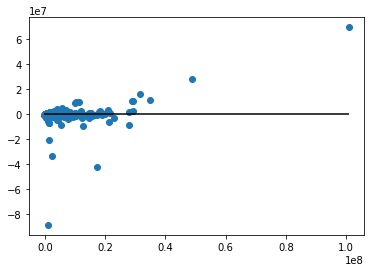

In [34]:
#plot residuals
import matplotlib.pyplot as plt
plt.scatter(y_pred_lin, y_pred_lin-y_test)
plt.hlines(y=0, xmin=y_pred_lin.min(), xmax=y_pred_lin.max())
plt.show()

##Random Forest Regression Model

In [51]:
random_model = RandomForestRegressor(n_estimators=100, random_state=1)
random_model.fit(X_train_scaled,y_train )
y_predict = random_model.predict(X_test_scaled)

In [52]:
mae, rmse, r_squared = evaluation(y_test, y_predict)
print("-"*30)
print("MAE:", mae)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)

------------------------------
MAE: 157076.38875835546
RMSE: 1194170.3553152692
R2 Score: 0.6242720255803786
------------------------------


In [53]:
print(f"Random Forest Regression Model Accuracy is {r_squared*100} %")

Random Forest Regression Model Accuracy is 62.42720255803786 %


In [54]:
# List the features sorted in descending order by feature importance
feature_importance = sorted(zip(random_model.feature_importances_, X.columns), reverse=True)
feature_importance 

[(0.8288863701566695, 'listed_price'),
 (0.020320505865842522, 'annual_tax_amount'),
 (0.016756813567097968, 'high_school_score'),
 (0.01581868350007886, 'tax_assesses_value'),
 (0.014335110275815025, 'cooling_features_Central'),
 (0.013540811687997041, 'total_interior_livable_area'),
 (0.011421475351690493, 'Housing_type_Condo'),
 (0.010529837874103186, 'last_sold_price'),
 (0.009500216272394252, 'bedrooms'),
 (0.005292732622710008, 'Housing_type_Townhouse'),
 (0.004949955946384173, 'Zip'),
 (0.004796913082359449, 'high_school_disctance'),
 (0.003884405274744729, 'elementary_school_distance'),
 (0.003790534333228345, 'middle_school_distance'),
 (0.003763531133897946, 'bathrooms'),
 (0.003711669447137547, 'Garage spaces'),
 (0.0027481963445514326, 'full_bathrooms'),
 (0.002590480143537565, 'Total spaces'),
 (0.0021012859968939242, 'Flooring_Other'),
 (0.0020040750233607132, 'elementary_school_score'),
 (0.001558339331341108, 'City_Other'),
 (0.0014422291559790692, 'heating_features_Cen

##Gradient Boost Regression Model

In [55]:
gradient_model = GradientBoostingRegressor(n_estimators=100, random_state=1)
gradient_model.fit(X_train_scaled,y_train )
y_predict = gradient_model.predict(X_test_scaled)

In [57]:
mae, rmse, r_squared = evaluation(y_test, y_predict)
print("MAE:", mae)
print("RMSE:", rmse)
print("R2 Score:", r_squared)

MAE: 164115.1995982871
RMSE: 1189489.0486606506
R2 Score: 0.6272120588886083


In [58]:
print(f"Gradient Boost Regression Model Accuracy is {r_squared*100} %")

Gradient Boost Regression Model Accuracy is 62.72120588886083 %


In [59]:
# List the features sorted in descending order by feature importance
feature_importance = sorted(zip(gradient_model.feature_importances_, X.columns), reverse=True)
feature_importance 

[(0.8889899473532833, 'listed_price'),
 (0.03423866116400815, 'annual_tax_amount'),
 (0.01988705396505771, 'cooling_features_Central'),
 (0.012013807279831283, 'last_sold_price'),
 (0.008674113849261257, 'Zip'),
 (0.008484729327068988, 'tax_assesses_value'),
 (0.0063091621822445095, 'total_interior_livable_area'),
 (0.006058779331211618, 'high_school_score'),
 (0.0032015627934819783, 'elementary_school_distance'),
 (0.002655886712377308, 'bedrooms'),
 (0.0018399773496865124, 'Housing_type_Townhouse'),
 (0.00086892869164095, 'Region_San Jose'),
 (0.0008184576502866181, 'Laundry features_Missing'),
 (0.0007463592675340685, 'bathrooms'),
 (0.0006693263394149323, 'elementary_school_score'),
 (0.0005532845603059435, 'high_school_disctance'),
 (0.0005352121393793662, 'full_bathrooms'),
 (0.0005312918306116424, 'Appliances included_Dishwasher'),
 (0.0004619392624231538, 'Appliances included_Dryer, Washer'),
 (0.0004031462876361164, 'middle_school_distance'),
 (0.0003532025270274604, 'cooling_

##XGBoost Regression Model


In [60]:
xgboost_model = XGBRegressor(max_depth=3, n_estimators=100, random_state=1)
xgboost_model.fit(X_train_scaled,y_train )
y_predict = xgboost_model.predict(X_test_scaled)

[22:07:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [61]:
mae, rmse, r_squared = evaluation(y_test, y_predict)
print("MAE:", mae)
print("RMSE:", rmse)
print("R2 Score:", r_squared)

MAE: 162337.58939023735
RMSE: 1196696.0456807972
R2 Score: 0.6226810028804096


In [62]:
print(f"XGBoost Regression Model Accuracy is {r_squared*100} %")

XGBoost Regression Model Accuracy is 62.26810028804096 %


In [63]:
# List the features sorted in descending order by feature importance
feature_importance = sorted(zip(xgboost_model.feature_importances_, X.columns), reverse=True)
feature_importance 

[(0.34410557, 'listed_price'),
 (0.14474836, 'Housing_type_Condo'),
 (0.11474546, 'annual_tax_amount'),
 (0.06056959, 'cooling_features_Central'),
 (0.04357861, 'Appliances included_Dryer, Washer'),
 (0.04245041, 'Housing_type_Townhouse'),
 (0.03441762, 'Zip'),
 (0.02903803, 'Laundry features_Missing'),
 (0.022315323, 'high_school_score'),
 (0.018925663, 'last_sold_price'),
 (0.017160833, 'Laundry features_Other'),
 (0.0121800825, 'tax_assesses_value'),
 (0.011637712, 'elementary_school_distance'),
 (0.009450514, 'cooling_features_Central AC'),
 (0.00942912, 'total_interior_livable_area'),
 (0.007832503, 'Total spaces'),
 (0.0076960977, 'Flooring_Missing'),
 (0.007635308, 'bedrooms'),
 (0.0072873146, 'middle_school_distance'),
 (0.0067250235, 'high_school_disctance'),
 (0.0060543427, 'full_bathrooms'),
 (0.0056391996, 'elementary_school_score'),
 (0.0055440804, 'heating_features_Other'),
 (0.0053652343, 'cooling_features_Missing'),
 (0.0053469143, 'Flooring_Hardwood'),
 (0.0049816817, 